In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

#HuggingFace tools
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

from google.colab import output

import urllib.request

In [2]:
output.disable_custom_widget_manager()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device Loaded: {device}")

# model_1 = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
# model_2 = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

distil_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

Device Loaded: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

In [3]:
# Load dataset
data_url = 'https://raw.githubusercontent.com/jeelfaldu7/transformer_sentiment_analysis/refs/heads/main/dataset.csv'
df = pd.read_csv(data_url, header=None, names=['id', 'text', 'label'], sep=',')

# Display first few rows of the dataset
display(df.head())

,id,text,label
0,611857364396965889,@aandraous @britishmuseum @AndrewsAntonio Merc...,nocode
1,614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy
2,614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy
3,614877582664835073,@Sofabsports thank you for following me back. ...,happy
4,611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy


In [5]:
# Display the summary of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3085 entries, 0 to 3084
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      3085 non-null   int64 
 1   text    3085 non-null   object
 2   label   3085 non-null   object
dtypes: int64(1), object(2)
memory usage: 72.4+ KB


In [6]:
df = df.drop('id', axis = 1)

In [7]:
# Display the shape of all the DataFrame
n_rows, n_cols = df.shape
print(f"The DataFrame has {n_rows} rows and {n_cols} columns")

The DataFrame has 3085 rows and 2 columns


In [8]:
# Check for duplicates in the 'final' DataFrame
df.duplicated().sum(),df['label'].unique()

(np.int64(37),
 array(['nocode', 'happy', 'not-relevant', 'angry', 'disgust|angry',
        'disgust', 'happy|surprise', 'sad', 'surprise', 'happy|sad',
        'sad|disgust', 'sad|angry', 'sad|disgust|angry'], dtype=object))

In [9]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

X_train = train_df.drop('label', axis = 1)
X_test = test_df.drop('label', axis = 1)

mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(train_df['label'].str.split('|'))
y_test = mlb.transform(test_df['label'].str.split('|'))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2468, 1) (2468, 7)
(617, 1) (617, 7)


In [10]:
print(mlb.classes_)
print(y_train[92])

['angry' 'disgust' 'happy' 'nocode' 'not-relevant' 'sad' 'surprise']
[0 0 1 0 0 0 0]


In [11]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [12]:
X2_train = X_train['text'].apply(preprocess)
X2_test = X_test['text'].apply(preprocess)

X2_train.head()

,text
2634,"I'm at @user in London, Greater London http"
2373,My favourite #oilpainting 'Tiger Tiger Burnin...
839,Currently @user to discuss #DefeatingDepressio...
2857,@user thanks for the Favourite!
761,Farron Gorey selfies before his performance at...


In [13]:
roberta_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [14]:
X2_train_tokens = roberta_tokenizer(X2_train.tolist(),
                                    padding=True,
                                    truncation=True,
                                    max_length=128,
                                    return_tensors="pt")

X2_test_tokens = roberta_tokenizer(X2_test.tolist(),
                                    padding=True,
                                    truncation=True,
                                    max_length=128,
                                    return_tensors="pt")

In [15]:
base_sentiments = base_sentiments = mlb.classes_

label2id = {label: idx for idx, label in enumerate(base_sentiments)}
id2label = {idx: label for idx, label in enumerate(base_sentiments)}

In [16]:
model_2 = AutoModelForSequenceClassification.from_pretrained(
    "cardiffnlp/twitter-roberta-base-sentiment",
    num_labels=len(base_sentiments),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
    problem_type="multi_label_classification"
).to(device)

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
train_dataset = Dataset.from_dict({
    'input_ids': X2_train_tokens['input_ids'],
    'attention_mask': X2_train_tokens['attention_mask'],
    'labels': y_train.astype('float32').tolist()
})

test_dataset = Dataset.from_dict({
    'input_ids': X2_test_tokens['input_ids'],
    'attention_mask': X2_test_tokens['attention_mask'],
    'labels': y_test.astype('float32').tolist()
})

In [18]:
output.disable_custom_widget_manager()

training_args = TrainingArguments(output_dir="./sentiment-model",
                                  num_train_epochs=4,
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=16,
                                  learning_rate=5e-5,
                                  weight_decay=0.1,
                                  eval_strategy="epoch",
                                  save_strategy="epoch",
                                  load_best_model_at_end=True,
                                  report_to="none",
                                  seed = 42)

roberta_trainer = Trainer(model=model_2,
                  args=training_args,
                  train_dataset=train_dataset,
                  eval_dataset=test_dataset,
                  processing_class=roberta_tokenizer)

roberta_trainer.train()

model_2.save_pretrained("./my-sentiment-model")
roberta_tokenizer.save_pretrained("./my-sentiment-model")

Epoch,Training Loss,Validation Loss
1,No log,0.164426
2,No log,0.156688
3,No log,0.165524
4,0.124200,0.172402


('./my-sentiment-model/tokenizer_config.json',
 './my-sentiment-model/special_tokens_map.json',
 './my-sentiment-model/vocab.json',
 './my-sentiment-model/merges.txt',
 './my-sentiment-model/added_tokens.json',
 './my-sentiment-model/tokenizer.json')

In [20]:
def predict_sentiments_debug(text, threshold=0.5):
    inputs = roberta_tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model_2(**inputs)

    logits = outputs.logits
    probs = torch.sigmoid(logits)[0].cpu().numpy()

    print("All probabilities:")
    for idx, prob in enumerate(probs):
        sentiment = id2label[idx]
        print(f"  {sentiment}: {prob:.4f}")

    predictions = {}
    for idx, prob in enumerate(probs):
        sentiment = id2label[idx]
        if prob >= threshold:
            predictions[sentiment] = float(prob)

    return predictions

result = predict_sentiments_debug("I'm so scared of the recent politcs from both parties", threshold=0.3)
print(f"Sentiments: {result}")

All probabilities:
  angry: 0.3630
  disgust: 0.0774
  happy: 0.2103
  nocode: 0.0491
  not-relevant: 0.0679
  sad: 0.2245
  surprise: 0.1702
Sentiments: {'angry': 0.36299774050712585}


<div style="border: 2px solid #1E90FF; background-color: #E6F0FF; padding: 10px; border-radius: 5px;">
Here is the graph of our sentiment Label Distribution. </div>

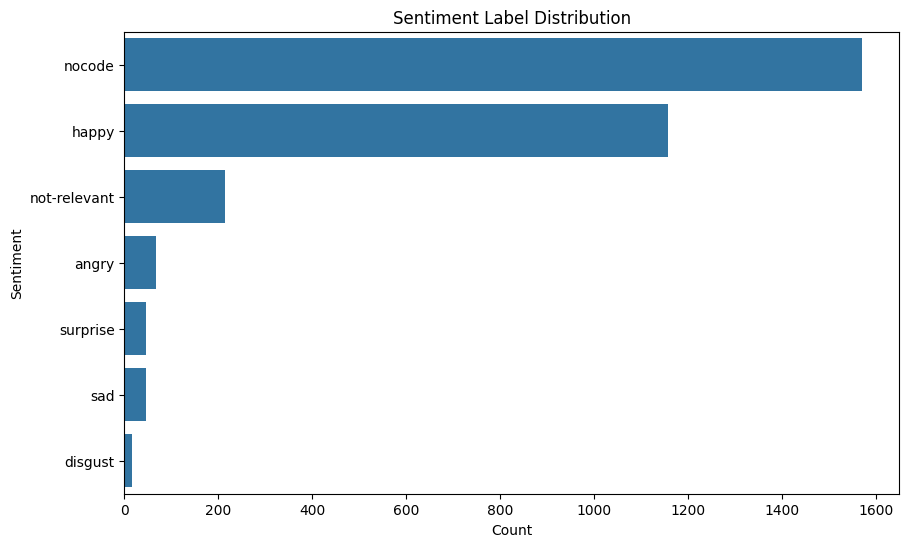

In [21]:
# Explode multi-labels
df['label_split'] = df['label'].str.split('|')
exploded_labels = df.explode('label_split')

plt.figure(figsize=(10, 6))
sns.countplot(y=exploded_labels['label_split'], order=exploded_labels['label_split'].value_counts().index)
plt.title("Sentiment Label Distribution")
plt.xlabel("Count")
plt.ylabel("Sentiment")
plt.show()

<font size="5">We have the most frequent `nocode` but has a 4 percent probability in our prediction model.

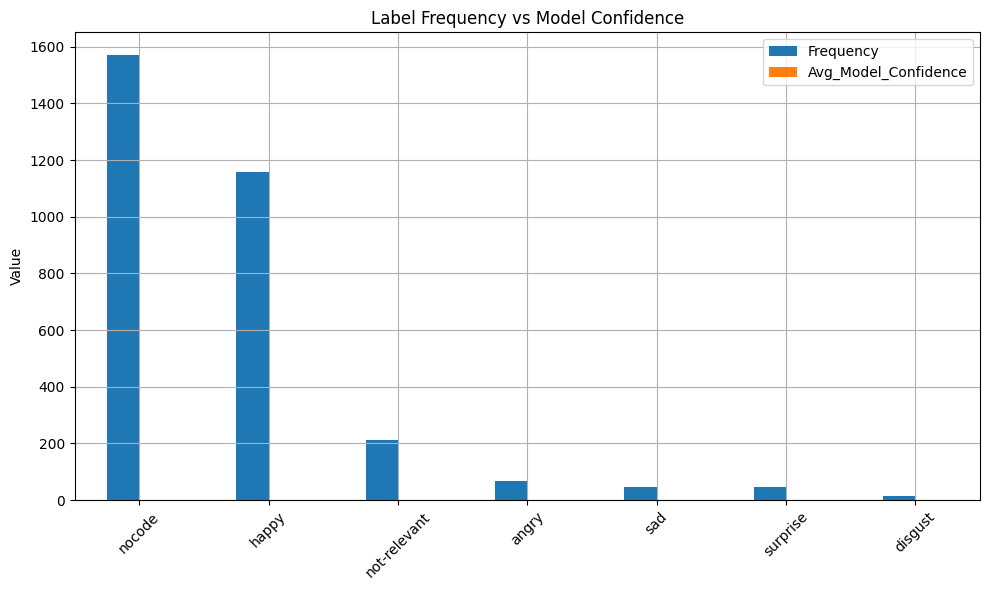

In [24]:
# Calculate average predicted probability per label in test set
preds = roberta_trainer.predict(test_dataset)
probs = torch.sigmoid(torch.tensor(preds.predictions)).numpy()
avg_probs = probs.mean(axis=0)

# Label frequency
label_freq = exploded_labels['label_split'].value_counts().sort_index()
avg_probs_series = pd.Series(avg_probs, index=mlb.classes_)

# Combine into one DataFrame
analysis_df = pd.DataFrame({
    'Frequency': label_freq,
    'Avg_Model_Confidence': avg_probs_series
})

# Plot
analysis_df.sort_values('Frequency', ascending=False).plot(kind='bar', figsize=(10,6))
plt.title('Label Frequency vs Model Confidence')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


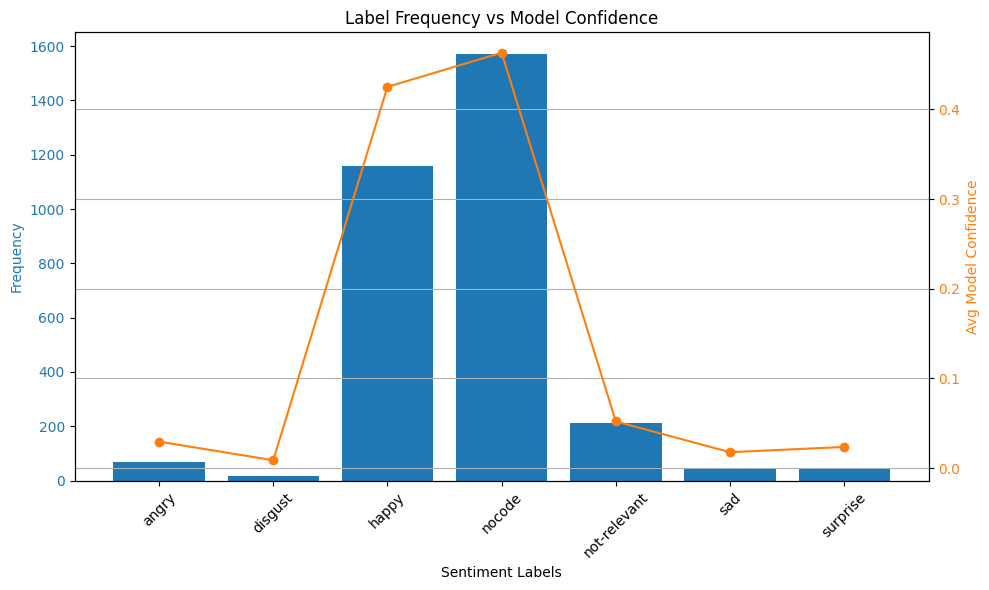

In [25]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for frequency (left y-axis)
color = 'tab:blue'
ax1.set_xlabel('Sentiment Labels')
ax1.set_ylabel('Frequency', color=color)
ax1.bar(analysis_df.index, analysis_df['Frequency'], color=color, label='Frequency')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=45)

# Twin axis for model confidence (right y-axis)
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Avg Model Confidence', color=color)
ax2.plot(analysis_df.index, analysis_df['Avg_Model_Confidence'], color=color, marker='o', label='Avg_Model_Confidence')
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout
plt.title('Label Frequency vs Model Confidence')
fig.tight_layout()
plt.grid(True)
plt.show()
